<a href="https://colab.research.google.com/github/shaleenanuj/Machine-Condition-Monitoring/blob/shaleen/ProphetFBPredictiononNASABearing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New Section

# CONDITION MONITORING & PREDICTIVE MAINTENANCE 


<font color="blue">This notebook is intended to illustrate conditioning monitoring of industrial machinery by walking  through a real life dataset of bearing vibration data.</font>








# Imports

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# Data Import

Data can be imported either by reading the file data and taking average of 10 minutes or can be read out of all ready stored file

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###Data read from raw data files
data_dir = 'data'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

In [7]:
merged_data = pd.read_csv('/content/drive/MyDrive/merged_dataset_BearingTest_2.csv')
merged_data.index = pd.to_datetime(merged_data['Unnamed: 0'])
merged_data.drop('Unnamed: 0',axis=1)
merged_data = merged_data.sort_index()

In [8]:
# Check - Begining of Data
merged_data.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
Unnamed: 0,,,,,
2004-02-12 10:32:39,2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [9]:
# Check - End of Data
merged_data.tail()
#Check Total Points
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 985


# Visualising the Data

Text(2004-02-19 06:12:39, 0.3, 'Breakdown of Bearing 1')

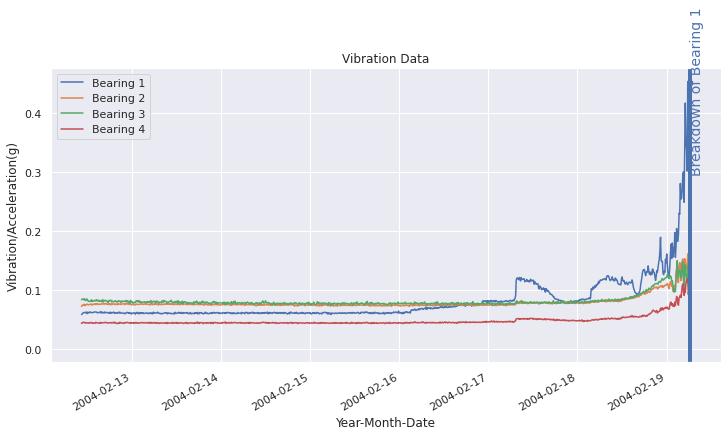

In [10]:
# Visualising Data
ax = merged_data.plot(figsize = (12,6), title="Vibration Data" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")
plt.axvline(x='2004-02-19 06:12:39', linewidth=4, color='b', label ="Breakdown of Bearing 1")
plt.text('2004-02-19 06:12:39',0.3,'Breakdown of Bearing 1',rotation=90, fontsize=14, color='b')

In [11]:
from fbprophet import Prophet

# Creating Training Data Set and model

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Displaying Prophet plot


[Text(45.125, 0.5, 'Vibration/Acceleration(g)'),
 Text(0.5, 30.5, 'Month (MM)-Date(DD) Time')]

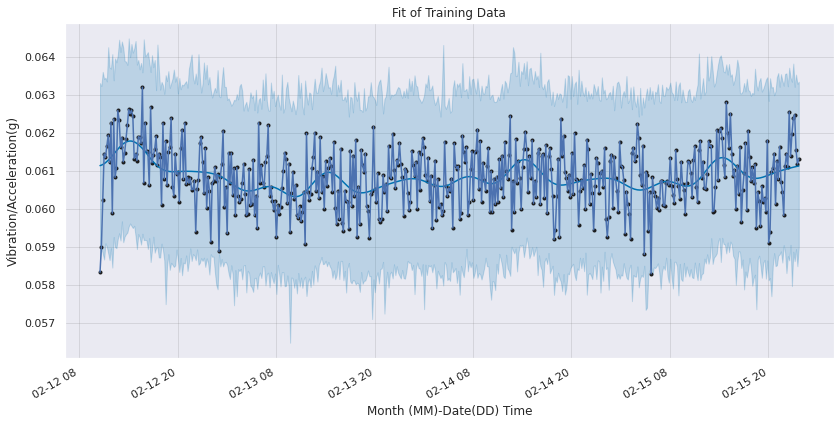

In [12]:
healthy_bearing1 = merged_data['2004-02-12 10:32:39':'2004-02-15 23:42:39']['Bearing 1']

# Creating training dataframe
prophet_healthy_train = pd.DataFrame()
prophet_healthy_train['ds'] = healthy_bearing1.index
prophet_healthy_train['y'] = healthy_bearing1.values

prophet_healthy_train.head()
m = Prophet(interval_width = 1)
# Using the training data from "healthy part"
m.fit(prophet_healthy_train)
forecast = m.predict(prophet_healthy_train)
forecast['fact'] = prophet_healthy_train['y'].reset_index(drop = True)
print('Displaying Prophet plot')
fig1 = m.plot(forecast)
fig1 = healthy_bearing1.plot(figsize = (12,6), title="Fit of Training Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")

Evaluation on test data

Displaying Prophet plot


Text(731624.875, 0.057, 'Actual/Healthy')

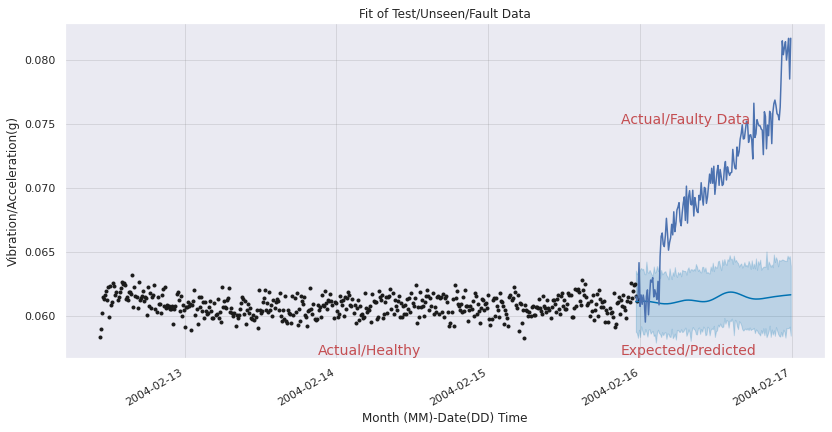

In [13]:
prophet_faultydata = merged_data['2004-02-15 23:22:39':'2004-02-16 23:52:39']['Bearing 1']
prophet_faultydata.head()

prophet_faulty_test = pd.DataFrame()

prophet_faulty_test['ds'] = prophet_faultydata.index
#pd.to_datetime(prophet_healthy.index, format='%Y.%m.%d.%H.%M.%S')
prophet_faulty_test['y'] = prophet_faultydata.values

forecast = m.predict(prophet_faulty_test)
forecast['fact'] = prophet_faulty_test['y'].reset_index(drop = True)
print('Displaying Prophet plot')
fig1 = m.plot(forecast)
fig1 = prophet_faultydata.plot(figsize = (12,6),title="Fit of Test/Unseen/Fault Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")
fig1.text(731626.875,0.057,'Expected/Predicted', fontsize=14, color='r')
fig1.text(731626.875,0.075,'Actual/Faulty Data', fontsize=14, color='r')
fig1.text(731624.875,0.057,'Actual/Healthy', fontsize=14, color='r')


In [14]:
# Healper functions to annotate the graph.
print(fig1.get_xticks())
print(fig1.get_yticks())

[731624. 731625. 731626. 731627. 731628.]
[0.055 0.06  0.065 0.07  0.075 0.08  0.085]


# References
1.   https://www.plantengineering.com/articles/roller-bearings-and-predictive-analytics/
2.   https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7
3. https://iot.ieee.org/images/files/pdf/phm2017/06-19-2017-Rick-Durham_IEEE-PHM_Presentation20170610.pdf
4. https://facebook.github.io/prophet/docs/quick_start.html
5. https://colab.research.google.com/github/arunptp/Predictive-Analytics/blob/master/BearingAnalytics_.ipynb?authuser=1#scrollTo=U0HbXUA0Sofp